# **Reinforcement Learning: An Introduction** - Chapter 6 
Thomas Hopkins

## **Exercise 6.1**
Given the scenario offered in the book, moving to a new building for work but entering the highway at the same place on your way home gives a big advantage for TD methods compared to Monte Carlo methods. This is because with a large amount of experience driving home from the old building, the estimate for the time it takes to get home from the highway entrance is very accurate. This data is utilized by TD methods but *not* by Monte Carlo methods. This is one way in which boostrapping is powerful. It can rapidly adapt to changes when new states are encountered. This kind of thing happens even in the original scenario, coming home from the old building.

## **Exercise 6.2**
This does not tell much about what happened in the first episode other than that the episode terminated on the left. The update to the value occured as
$$V(A) = 0.5 + 0.1(0.0 + (1.0)(0.0) - 0.5) = 0.5 - 0.05 = 0.45$$ 
This is because the value of terminal states are always $0$, by definition.

## **Exercise 6.3**
Given only 100 episodes, I do not think that changing the value of $\alpha$ would lower the RMS error. Given a larger, but still finite, number of episodes, a lower $\alpha$ would be better since it will take smaller steps. The problem with a limit of 100 episodes to learn from is that a smaller $\alpha$ may not converge by the time that limit is reached. One could get the best of both worlds by decreasing the learning rate as the number of episodes increases, however, finding the correct schedule for decreasing the learning rate is its own problem.

## **Exercise 6.4**
As learning continues, this will always occur. The severity of this issue depends on the size of the learning rate, $\alpha$. TD methods continue to update the states using this learning rate, so fluctuations can occur and errors can propagate. This could be an issue of how the approximate value function was initialized since it could have introduced bias into the function that would be difficult to unlearn. For instance, $V(A) = 0.5$ is quite far from its true value while $V(C) = 0.5$ is spot on.

## **Exercise 6.5**
One way is by reasoning that $V(C) = 0.5$ and then we can compute the values of all of the other states by solving a system of linear equations. The other way is by using dynamic programming methods. Solving the linear system is probably easier.

The linear system would be
$$V(C) = \frac{1}{2}$$
$$V(A) = \frac{V(B)}{2}$$
$$V(B) = \frac{V(A) + V(C)}{2}$$
$$V(D) = \frac{V(C) + V(E)}{2}$$
$$V(E) = \frac{1 + V(D)}{2}$$

## **Exercise 6.6**
Here is my implementation of the Windy Gridworld environment. As we can see, including diagonal moves allows us to reach the goal in only 8 steps compared to 16 steps without. Allowing for no movement as a 9th action, we also reach the goal in 8 steps but along a different path.

In [95]:
using Base.Iterators
using Random
using Plots
gr()

STATES = collect(product(1:7, 1:10))
#ACTIONS = [(0, -1), (-1, 0), (0, 1), (1, 0)] # (left, up, right, down)
#ACTIONS = collect(product(-1:1, -1:1)) # all cardinal directions including no action
ACTIONS = [(-1, -1), (-1, 0), (-1, 1),  # all cardinal directions
           (0, -1), (0, 1),
           (1, -1), (1, 0), (1, 1)]
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
START = (4, 1)
GOAL = (4, 8)
    

function select_action(Q_values, state; epsilon = 0.1)
    if rand() < epsilon
        return rand(ACTIONS)
    end
    return argmax(Q_values[state])
end

function step(state, action)
    new_state = [state[1] + action[1], state[2] + action[2]]
    new_state[1] -= WIND[state[2]]
    if new_state[1] <= 0
        new_state[1] = 1
    elseif new_state[1] > 7
        new_state[1] = 7
    end
    if new_state[2] <= 0
        new_state[2] = 1
    elseif new_state[2] > 10
        new_state[2] = 10
    end
    new_state = (new_state[1], new_state[2])
    reward = -1.0
    terminated = false
    if new_state == GOAL
        reward = 0.0
        terminated = true
    end
    return reward, new_state, terminated
end

function sarsa!(Q_values; num_episodes = 1000, epsilon = 0.1, alpha = 0.1, gamma = 1.0)
    for e = 1:num_episodes
        state = START
        action = select_action(Q_values, state; epsilon = epsilon)
        terminated = false
        while !terminated
            reward, new_state, terminated = step(state, action)
            new_action = select_action(Q_values, new_state; epsilon = epsilon)
            Q_values[state][action] += alpha * (reward + gamma * Q_values[new_state][new_action] - Q_values[state][action])
            state = new_state
            action = new_action
        end
    end
    return Q_values
end

function eval(Q_values)
    grid = zeros(Int, 7, 10)
    state = START
    action = select_action(Q_values, state; epsilon = 0.0)
    terminated = false
    while !terminated
        grid[state[1], state[2]] = 1
        reward, new_state, terminated = step(state, action)
        new_action = select_action(Q_values, new_state; epsilon = 0.0)
        state = new_state
        action = new_action
    end
    grid[state[1], state[2]] = 1
    return heatmap(reverse(grid; dims=1))
end

eval (generic function with 1 method)

Using action set: [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]


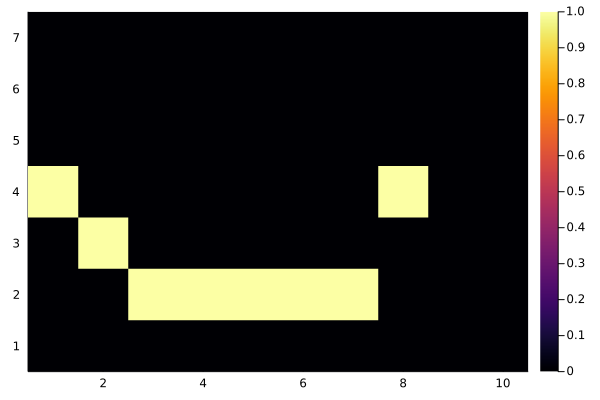

In [101]:
Random.seed!(32)
println("Using action set: $(ACTIONS)")
Q_values = Dict(s => Dict(a => 0.0 for a in ACTIONS) for s in STATES)
Q_updated = sarsa!(Q_values)
eval(Q_updated)

## **Exercise 6.7**